In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../data"))

# Any results you write to the current directory are saved as output.


['.local', 'video', 'label_names_2018.csv', 'test', 'GCP-Credits.rtf', 'frame', '__MACOSX', 'sample_submission.csv', 'vocabulary.csv', '.~lock.vocabulary.csv#', 'get_data.sh']


In [2]:
print(os.listdir("../data/frame"))
print(os.listdir("../data/video"))

['train2072.tfrecord', 'train1745.tfrecord', 'train1864.tfrecord', 'train0276.tfrecord', 'test0100.tfrecord', 'validate2394.tfrecord', 'validate2094.tfrecord', 'test0285.tfrecord', 'test2226.tfrecord', 'validate3182.tfrecord', 'test1114.tfrecord', 'train3519.tfrecord', 'validate1937.tfrecord', 'train0503.tfrecord', 'train0580.tfrecord', 'test2057.tfrecord', 'validate1116.tfrecord', 'train3551.tfrecord', 'train1110.tfrecord', 'test3212.tfrecord', 'validate2517.tfrecord', 'validate2525.tfrecord', 'test2501.tfrecord', 'validate1219.tfrecord', 'validate0052.tfrecord', 'train0667.tfrecord', 'train3560.tfrecord', 'test3392.tfrecord', 'test0397.tfrecord', 'validate1704.tfrecord', 'validate1932.tfrecord', 'test2108.tfrecord', 'validate0797.tfrecord', 'test2560.tfrecord', 'validate0965.tfrecord', 'train3477.tfrecord', 'test0162.tfrecord', 'train1087.tfrecord', 'validate0267.tfrecord', '2_frame_train_download_plan.json', 'validate3731.tfrecord', 'train3220.tfrecord', 'validate3043.tfrecord', 'tr

In [7]:
#Loading libraries & datasets
import tensorflow as tf
import numpy as np
from IPython.display import YouTubeVideo

video_lvl_record = "../data/video/train2072.tfrecord"
frame_lvl_record = "../data/frame/train2072.tfrecord"

In [8]:
vid_ids = []
labels = []
mean_rgb = []
mean_audio = []

for example in tf.python_io.tf_record_iterator(video_lvl_record):
    tf_example = tf.train.Example.FromString(example)

    vid_ids.append(tf_example.features.feature['id'].bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)
    mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
    mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)

In [9]:
print('Number of videos in this tfrecord: ',len(mean_rgb))
print('Picking a youtube video id:',vid_ids[13])
print('First 20 features of a youtube video (',vid_ids[13],'):')
print(mean_rgb[13][:20])

Number of videos in this tfrecord:  977
Picking a youtube video id: C8HA
First 20 features of a youtube video ( C8HA ):
[0.537328839302063, 0.09894975274801254, 1.6871850490570068, 0.1870020478963852, 0.0548713244497776, -0.3643704950809479, 0.11928962171077728, -0.2632986009120941, 0.8155510425567627, 0.8471850752830505, -0.8149848580360413, 0.5752896070480347, 0.3801000714302063, -0.7488411068916321, 0.07348570227622986, 0.2483876645565033, -1.0287888050079346, -0.42565155029296875, 0.14945955574512482, -0.20442278683185577]


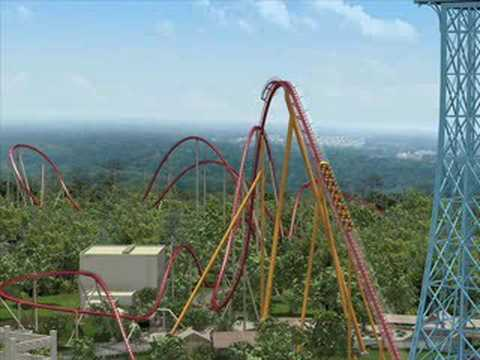

In [10]:
#With that video id, we can play the video
YouTubeVideo('-QM5ooctj0w')

In [11]:


# due to execution time, we're only going to read the first video

feat_rgb = []
feat_audio = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):        
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    feat_rgb.append(rgb_frame)
    feat_audio.append(audio_frame)
    break



In [12]:
print('The first video has %d frames' %len(feat_rgb[0]))

The first video has 149 frames


In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import numpy as np

ModuleNotFoundError: No module named 'matplotlib'

In [15]:


n=10
from collections import Counter
label_mapping = pd.read_csv('../data/label_names_2018.csv',header=0,index_col=0,squeeze=True).T.to_dict()

top_n = Counter([item for sublist in labels for item in sublist]).most_common(n)
top_n_labels = [int(i[0]) for i in top_n]
top_n_label_names = [label_mapping[x] for x in top_n_labels]
top_n_label_names



['Game',
 'Vehicle',
 'Concert',
 'Video game',
 'Car',
 'Animation',
 'Dance',
 'Association football',
 'Musician',
 'Food']

In [16]:
import networkx as nx
from itertools import combinations

G=nx.Graph()

G.clear()
for list_of_nodes in labels:
    filtered_nodes = set(list_of_nodes).intersection(set(top_n_labels))  
    for node1,node2 in list(combinations(filtered_nodes,2)): 
        node1_name = label_mapping[node1]
        node2_name = label_mapping[node2]
        G.add_node(node1_name)
        G.add_node(node2_name)
        G.add_edge(node1_name, node2_name)

nx.draw_networkx(G,font_size="10")

ModuleNotFoundError: No module named 'networkx'

In [17]:
colors = plt.cm.rainbow(np.linspace(0, 1, n))
mean_rgb_top_n = []
labels_for_tsne = []
# filtering mean_rgb so it only contains top n labels
for idx, list_of_nodes in enumerate(labels):
    for node in list_of_nodes:
        if node in top_n_labels:
            mean_rgb_top_n.append(mean_rgb[idx])
            labels_for_tsne.append(node)


X_embedded = TSNE(n_components=2, random_state=0).fit_transform(mean_rgb_top_n) 


fig = plt.figure()
ax = fig.add_subplot(111)

handles = []
for indx, color in enumerate(colors):
    this_label = top_n_labels[indx]
    X_embedded_filtered = X_embedded[np.array([x==this_label for x in labels_for_tsne])]
    handles.append(ax.scatter(X_embedded_filtered[:, 0], X_embedded_filtered[:, 1], c=color, marker="o",edgecolor='none'))

ax.legend(handles, top_n_labels)

plt.show()

NameError: name 'plt' is not defined